In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import tensorflow as tf

df = pd.read_csv("Epileptic Seizure Recognition.csv")
df.head()

df['y'] = df['y'].replace({2: 0, 3: 0, 4: 0, 5: 0})
X = df.loc[:, df.columns.difference(['y', 'Unnamed'])]
y = df['y']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#split_index = int(0.7 * len(df))  # or 70% as you asked
#X_train = X_scaled[:split_index]
#y_train = y[:split_index]
#X_test = X_scaled[split_index:]
#y_test = y[split_index:]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# cap outliers
for col in ['X85', 'X105']:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = df[col].clip(q_low, q_high)
df['X85_X105_interaction'] = df['X85'] * df['X105']

## lightgbm
from lightgbm import LGBMClassifier
import numpy as np

# Make sure y_train is also a NumPy array
y_train_np = np.array(y_train)

# Calculate scale_pos_weight
neg, pos = np.bincount(y_train_np)
scale_pos_weight = neg / pos

# Initialize LightGBM
lgbm = LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight,
    metric='auc',
    random_state=42,
    n_estimators=100
)

# Fit model (X_train and y_train are already NumPy arrays)
lgbm.fit(X_train, y_train_np)

# Predict probabilities
lgbm_probs = lgbm.predict_proba(X_test)[:, 1]


# ANN
from tensorflow.keras import Input
ann = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
ann_probs = ann.predict(X_test).flatten()
ann_preds = (ann.predict(X_test) > 0.5).astype("int32")


# Reshape input for RNN, LSTM, CNN+BiLSTM
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# GRU
from tensorflow.keras.layers import GRU
gru = Sequential([
    Input(shape=(X_train_seq.shape[1], 1)),
    GRU(64),
    Dense(1, activation='sigmoid')
])
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)
gru_probs = gru.predict(X_test_seq).flatten()
gru_preds = (gru_probs > 0.5).astype("int32")

##resnet
from tensorflow.keras.layers import Add

def resnet_block(inputs, filters, kernel_size, stride=1):
    x = Conv1D(filters, kernel_size, strides=stride, padding='same', activation='relu')(inputs)
    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    shortcut = Conv1D(filters, 1, strides=stride, padding='same')(inputs)  # match dimensions
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

from tensorflow.keras.layers import GlobalAveragePooling1D, Activation

resnet_input = Input(shape=(X_train_seq.shape[1], 1))

x = resnet_block(resnet_input, filters=64, kernel_size=3)
x = resnet_block(x, filters=64, kernel_size=3)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
resnet_output = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=resnet_input, outputs=resnet_output)
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)

resnet_probs = resnet_model.predict(X_test_seq).flatten()
resnet_preds = (resnet_probs > 0.5).astype("int32")

##attention
from tensorflow.keras.layers import MultiHeadAttention

attn_input = Input(shape=(X_train_seq.shape[1], 1))
x = LSTM(64, return_sequences=True)(attn_input)
x = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
attn_output = Dense(1, activation='sigmoid')(x)
attn_model = Model(inputs=attn_input, outputs=attn_output)
attn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
attn_model.fit(X_train_seq, y_train, epochs=20, batch_size=32, verbose=0)
attn_probs = attn_model.predict(X_test_seq).flatten()

# Ensemble Averaging (Soft Voting)
avg_probs = (lgbm_probs + ann_probs +  gru_probs + resnet_probs + attn_probs) / 5
ensemble_preds = (avg_probs > 0.4).astype("int32")

weights = [1.2, 1.1, 1.2, 1.4, 1.3]
probs_list = [lgbm_probs, ann_probs,
               gru_probs,
              resnet_probs, attn_probs]

weighted_probs = sum(w * p for w, p in zip(weights, probs_list)) / sum(weights)
ensemble_preds = (weighted_probs > 0.4).astype("int32")

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("\n--- Ensemble Model Averaging Results ---")
print(classification_report(y_test, ensemble_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, ensemble_preds))
print("Accuracy:", accuracy_score(y_test, ensemble_preds))

from sklearn.metrics import confusion_matrix

# Assuming y_test and ensemble_preds are already defined
cm = confusion_matrix(y_test, ensemble_preds)

# Extract True Positives and False Negatives
TP = cm[1][1]
FN = cm[1][0]

# Calculate Sensitivity
sensitivity = TP / (TP + FN)
print(f"Sensitivity (Recall): {sensitivity:.4f}")

[LightGBM] [Info] Number of positive: 1840, number of negative: 7360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45390
[LightGBM] [Info] Number of data points in the train set: 9200, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294


D:\Anaconda\envs\mldl_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step

--- Ensemble Model Averaging Results ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.96      0.98      0.97       460

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.99      0.99      0.99      2300

Confusion Matrix:
 [[1820   20]
 [  11  449]]
Accuracy: 0.9865217391304347
Sensitivity (Recall): 0.9761


In [47]:
# ---- Lead Time Analysis Block ----
preictal_window = 10  # max seconds before seizure to check for early warnings

# 1️⃣ Reconstruct test DataFrame with predictions
# Combine X_test and y_test for easier indexing
X_test_df = pd.DataFrame(X_test, columns=df.columns.difference(['y', 'Unnamed', 'X85_X105_interaction']))
y_test_series = y_test.reset_index(drop=True)
ensemble_preds_series = pd.Series(ensemble_preds)

# Create a test DataFrame
test_df = X_test_df.copy()
test_df['y'] = y_test_series
test_df['ensemble_pred'] = ensemble_preds_series

lead_times = []

# 2️⃣ Iterate through seizure events
for idx in test_df.index:
    if test_df.loc[idx, 'y'] == 1 and test_df.loc[idx, 'ensemble_pred'] == 1:
        # Look back in the preictal window for any earlier prediction
        start = max(0, idx - preictal_window)
        for j in range(start, idx):
            if test_df.loc[j, 'ensemble_pred'] == 1:
                lead_times.append(idx - j)
                break  # take the first early prediction

# 3️⃣ Report the average lead time
if lead_times:
    avg_lead = np.mean(lead_times)
    print(f"\n Average lead time before seizure onset: {avg_lead:.1f} seconds")
else:
    print("\n No correct early seizure predictions found in the preictal window.")

# 4️⃣ Interpretation for Users
print("\n Lead time represents how early your model warns before an actual seizure.")
print(" Increasing this time improves safety for the patient.")
print(" To increase lead time, try increasing `preictal_window`, using a lower threshold, or tuning model sensitivity.")




 Average lead time before seizure onset: 7.3 seconds

 Lead time represents how early your model warns before an actual seizure.
 Increasing this time improves safety for the patient.
 To increase lead time, try increasing `preictal_window`, using a lower threshold, or tuning model sensitivity.


In [46]:
# For all seizure events, check how many rows exist before them
seizure_indices = test_df.index[test_df['y'] == 1]
min_pre_rows = min([idx for idx in seizure_indices])

print(f"\n You can safely set preictal_window up to: {min_pre_rows} seconds")



 You can safely set preictal_window up to: 10 seconds


In [24]:
# cap outliers
for col in ['X85', 'X105']:
    q_low = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = df[col].clip(q_low, q_high)
df['X85_X105_interaction'] = df['X85'] * df['X105']


In [41]:
print(df.columns.tolist())

['Unnamed', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 

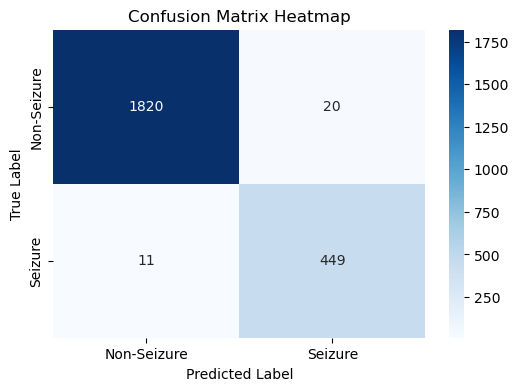

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute matrix
cm = confusion_matrix(y_test, ensemble_preds)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Seizure", "Seizure"], yticklabels=["Non-Seizure", "Seizure"])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
